In [1]:
import os
import glob
import math
import time
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import random
import seaborn as sns; sns.set_theme()
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import pylab as pl
from matplotlib.pyplot import figure
from IPython import display
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import umap
from sklearn import svm
from lightgbm import LGBMClassifier
from numpy import std
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import cm
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 300)

In [4]:
train = pd.read_csv('./MLR_Project_train.csv')
test = pd.read_csv('./MLR_Project_test.csv')

## 1.3 Show the maximum return of train and test

In [5]:
train_max = np.sum(train['TARGET'][train['TARGET']>0])
test_max = np.sum(test['TARGET'][test['TARGET']>0])

print('Maximum return of training set:', train_max)
print('Maximum return of testing set:', test_max)

Maximum return of training set: 195.6927566509
Maximum return of testing set: 55.96225182400002


### 1.3.1 Remove the Unnamed columns in dataframe

In [6]:
train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]

In [7]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,TARGET
0,5874.524387,1072.671848,41440.76212,41440.23732,70.405148,7.392780,70.377281,23229.69262,23229.72655,70.378864,7.389173,70.380160,23229.76782,23379.81637,83.418623,11.615135,83.418623,23466.72590,23466.72590,83.418623,7.425618,70.494241,23229.77107,23229.77107,70.376262,7.389056,70.376262,23229.77107,23229.77107,70.376262,4898.757333,15165.927590,297487.1654,297487.16540,15165.927590,4898.757333,70.376262,2.322977e+04,23229.77107,70.376262,7.389056,70.376262,23229.77107,23229.77107,64.192982,20.940618,76.070270,23376.73707,23343.13291,77.290965,347.308164,102.380501,24823.08137,24120.94894,332.757607,17.386711,129.622187,23936.99077,21670.192330,71.518948,11.399004,78.006816,26437.161240,23811.09670,141.997532,22.474794,0.013314
1,6124.154099,1072.802927,41440.76212,41442.22458,70.456758,7.356050,70.379576,23229.76020,23230.10472,70.273618,7.389813,70.329906,23229.46908,23384.98219,83.418623,11.615135,83.418623,23466.72590,23466.72590,83.418623,7.441223,70.702624,23229.77107,23229.77107,70.376262,7.389056,70.376262,23229.77107,23229.77107,70.376262,5100.350569,15788.076830,308790.4312,308790.43120,15788.076830,5100.350569,70.376262,2.322977e+04,23229.77107,70.376262,7.389056,70.376262,23229.77107,23229.77107,2.937218,-14.428210,75.204973,23317.46049,23309.42032,74.880368,689.670872,127.070357,36746.26762,31012.79786,-310.576721,4.532673,-47.045260,22053.23653,14626.733390,48.124991,-99.618253,-115.120518,7705.543821,22665.35143,-377.287072,-73.700375,-0.000448
2,5905.732593,1072.802927,41443.14358,41442.30403,70.422472,7.417794,70.376448,23229.48142,23229.61008,70.474265,7.388979,70.397301,23229.83396,23387.39168,83.418623,11.615135,83.418623,23466.72590,23466.72590,83.418623,7.440201,70.686178,23229.77107,23229.77107,70.376262,7.389056,70.376262,23229.77107,23229.77107,70.376262,5308.548086,16430.607950,320463.9968,320463.99680,16430.607950,5308.548086,70.376262,2.322977e+04,23229.77107,70.376262,7.389056,70.376262,23229.77107,23229.77107,141.231442,25.855392,75.184756,23248.26780,23307.91084,74.635569,634.523047,71.705965,28917.00549,24632.17456,419.071308,7.403187,118.846496,23430.24573,31251.552920,71.535567,53.482719,106.179152,37586.677270,23251.62576,261.098973,22.565621,0.000244
3,6029.325221,1072.802927,41440.76212,41442.25682,70.458533,7.366031,70.379221,23230.08433,23229.87971,70.288944,7.390120,70.370247,23229.81662,23390.02296,83.418623,11.615135,83.418623,23233.34325,23466.72590,83.418623,7.439191,70.692085,23229.77107,23229.77107,70.376262,7.389056,70.376262,23229.77107,23229.77107,70.376262,5510.265781,17053.141280,331774.2409,75710.89648,17053.141280,5510.265781,70.376262,2.322977e+04,23229.77107,70.376262,7.389056,70.376262,23229.77107,23229.77107,-1.580478,-7.499746,75.184756,23248.26836,23307.91084,74.635569,583.001082,70.384022,25642.94219,23482.26269,-249.671869,7.388974,49.809681,23193.67720,15867.015790,70.369496,-12.169114,63.930236,10052.351290,23229.64352,-10.549985,4.656636,-0.000628
4,6142.360146,1072.802927,41443.14358,41442.46480,70.413623,7.411287,70.376788,23229.70975,23229.82255,70.467206,7.389910,70.386986,23229.87603,23392.66710,70.572881,11.615135,83.418623,23466.72590,23466.72590,83.418623,7.438244,70.680386,23229.77107,23229.77107,70.376262,7.389056,70.376262,23229.77107,23229.77107,70.376262,1152.667997,17699.014450,343508.5253,343508.52530,17699.014450,5719.546213,70.376262,2.322977e+04,23229.77107,70.376262,7.389056,70.376262,23229.77107,23229.77107,149.144800,26.789196,74.904988,23229.77108,23260.32245,70.506980,566.549008,120.694073,25765.82131,24618.79392,363.188022,7.389057,78.826922,23235.86490,31790.064250,120.694068,42.971377,145.572170,37109.895810,24143.94971,188.639704,31.863254,0.003811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [8]:
train_ = (train.iloc[:, :-1]-train.iloc[:, :-1].mean())/train.iloc[:, :-1].std()
train_['TARGET'] = train['TARGET']
train = train_

test_ = (test.iloc[:, :-1]-test.iloc[:, :-1].mean())/test.iloc[:, :-1].std()
test_['TARGET'] = test['TARGET']
test = test_

## 1.4 Naive random selection experiment

In [9]:
train_random = 0
for j in range(10000):
    ind = np.random.randint(2, size=train.shape[0])
    train_random = train_random + sum(train['TARGET'][ind>0])

print('Result of train naive random selection:', train_random/10000)

test_random = 0
for j in range(10000):
    ind = np.random.randint(2, size=test.shape[0])
    test_random = test_random + sum(test['TARGET'][ind>0])

print('Result of test naive random selection:', test_random/10000)


Result of train naive random selection: -0.8058178938262315
Result of test naive random selection: -0.6435651994282775


In [10]:
print(f'Train naive random selection percentage return: {(train_random/10000)/train_max*100}%')
print(f'Test naive random selection percentage return: {(test_random/10000)/test_max*100}%')

Train naive random selection percentage return: -0.4117770670805896%
Test naive random selection percentage return: -1.1499987553257776%


In [11]:
train['group'] = 1

quantiles = [train['TARGET'].quantile(x/10) for x in range(1, 10)]

for i in range(train.shape[0]):
    for j in range(9):
        if train['TARGET'][i] < quantiles[j]:
            train['group'][i] = j
            break
        train['group'][i] = 9

In [12]:
test['group'] = 1

# quantiles = [test['TARGET'].quantile(x/10) for x in range(1, 10)]

for i in range(test.shape[0]):
    for j in range(9):
        if test['TARGET'][i] < quantiles[j]:
            test['group'][i] = j
            break
        test['group'][i] = 9

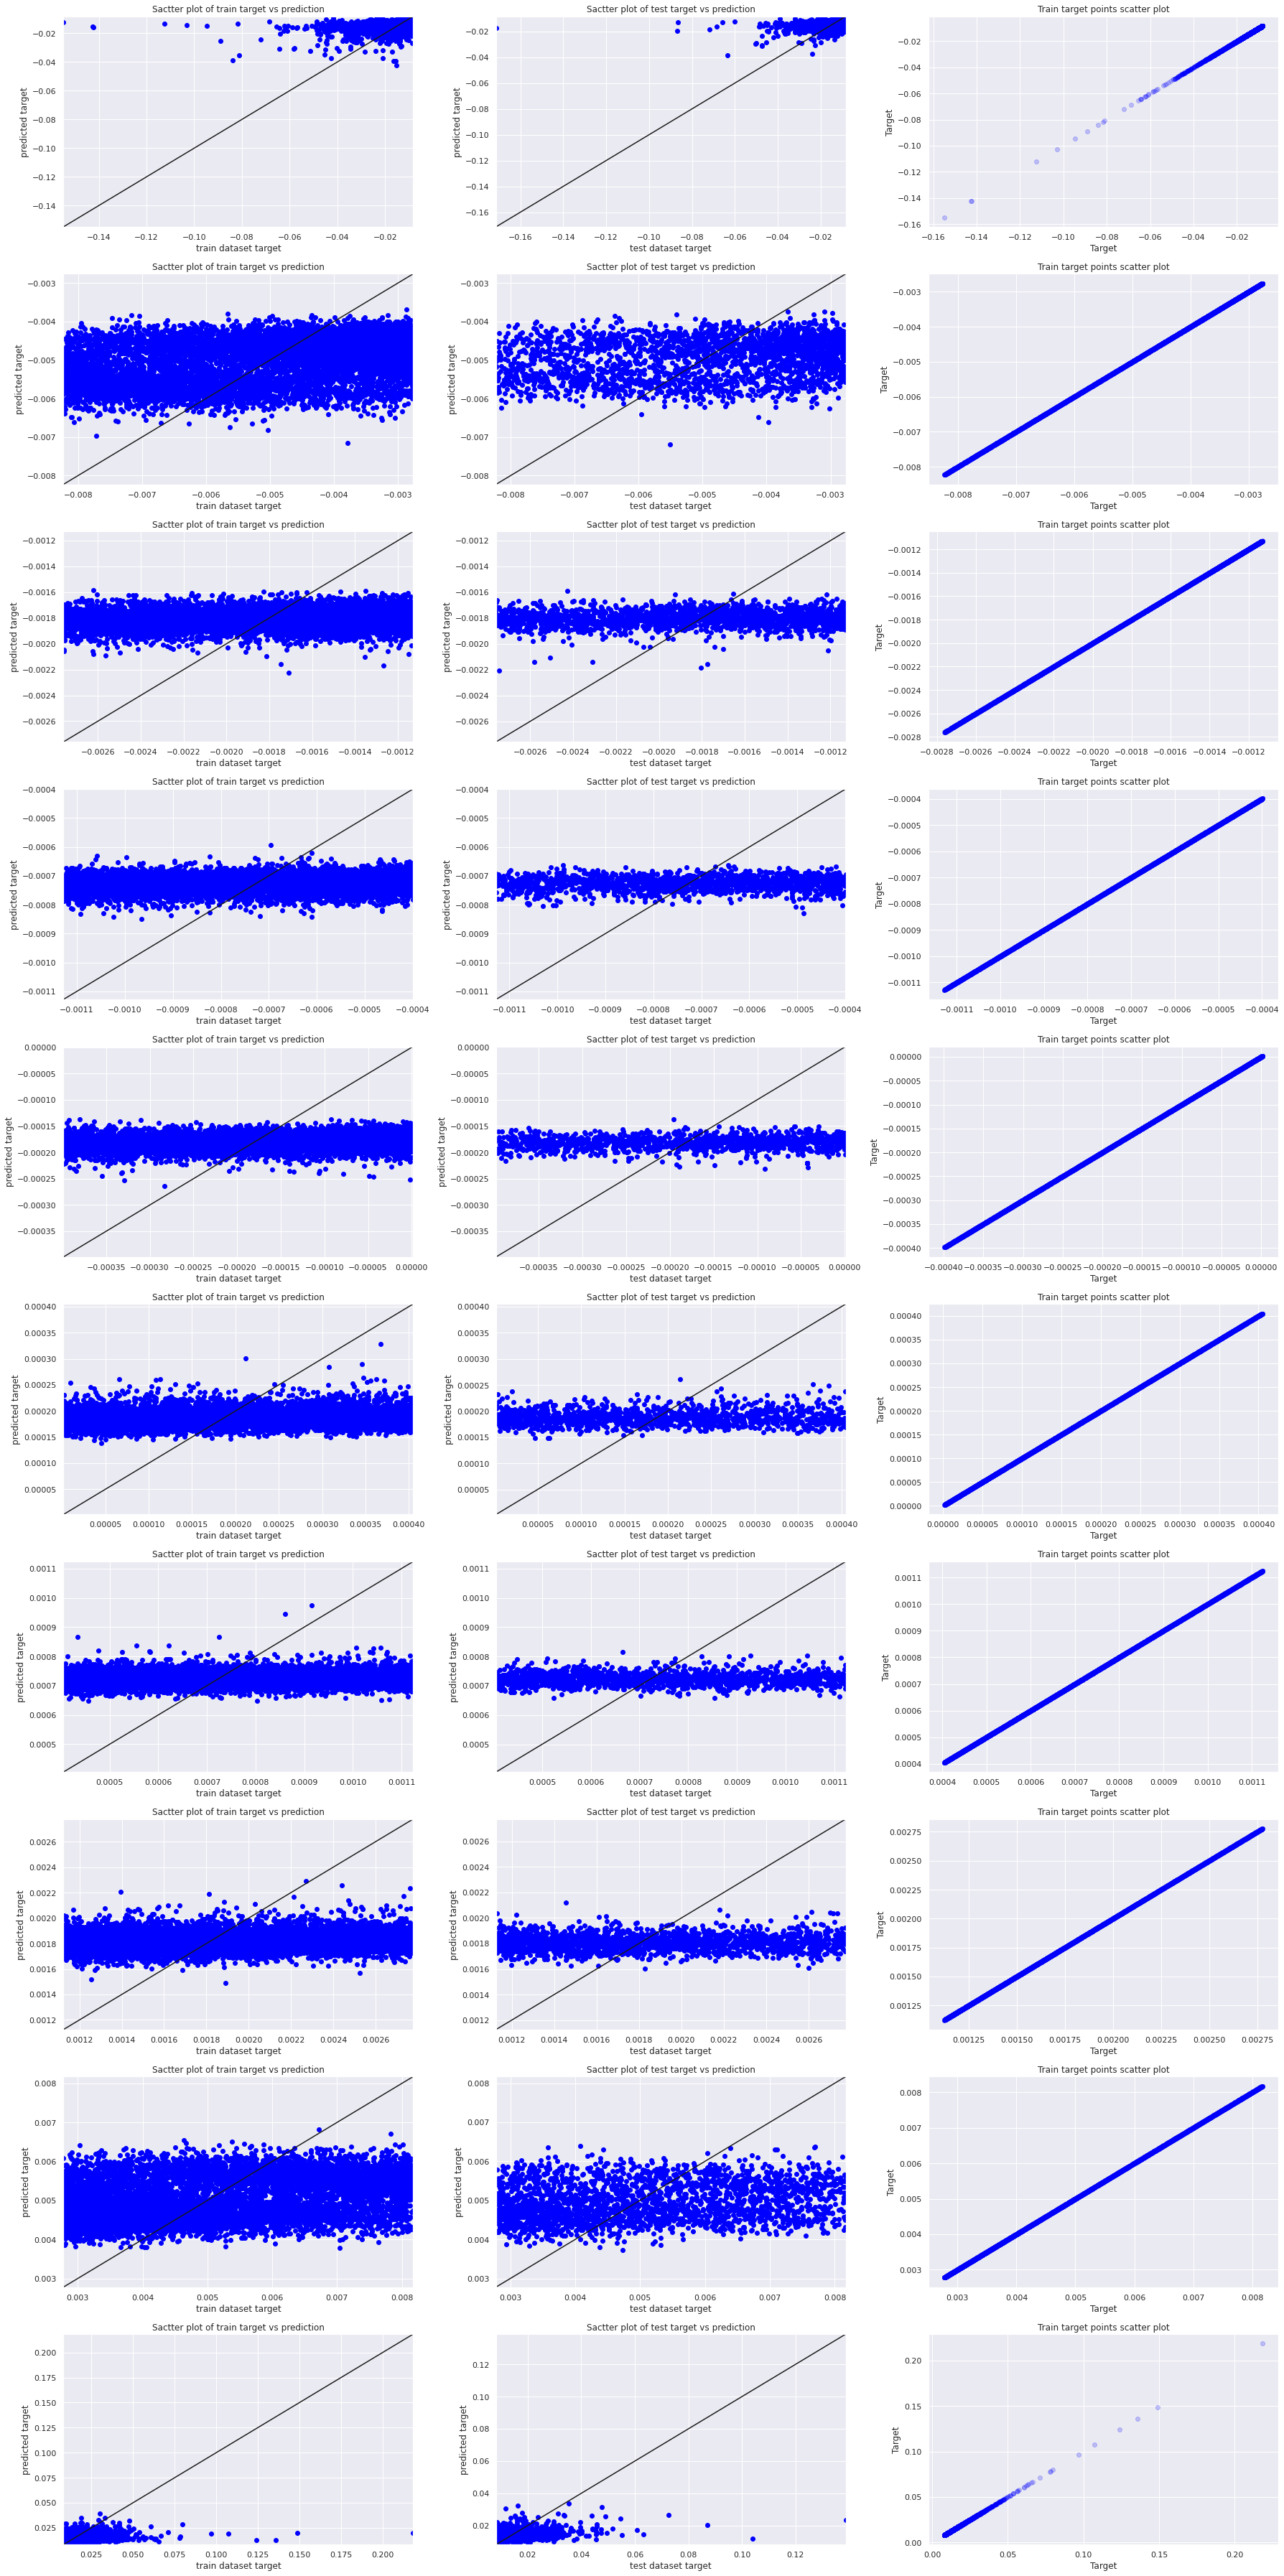

In [13]:
fig, ax = plt.subplots(10, 3, figsize = (25, 50))

quantiles_num = []
train_sum_returns = []
test_sum_returns = []

models = []

for i in range(10):
    train_seg = train[train['group']==i]
    test_seg = test[test['group']==i]
    
    quantiles_num.append([train_seg, test_seg])
    
    reg = Ridge(alpha=0.5).fit(pd.DataFrame(train_seg.iloc[:, :66]), train_seg['TARGET'])
    
    models.append(reg)
    
    pred = reg.predict(pd.DataFrame(train_seg.iloc[:, :66]))

    pred_test = reg.predict(pd.DataFrame(test_seg.iloc[:, :66]))

    train_res = np.sum(train_seg['TARGET'][pred>0])
    test_res = np.sum(test_seg['TARGET'][pred_test>0])
    
    train_sum_returns.append(train_res)
    test_sum_returns.append(test_res)
    
    max_value = max(max(train_seg['TARGET']), max(pred))
    min_value = min(min(train_seg['TARGET']), min(pred))
    ax[i, 0].scatter(train_seg['TARGET'], pred, c = 'blue')
    ax[i, 0].plot([min_value, max_value], [min_value, max_value], 'k-')
    ax[i, 0].set_xlim([min_value, max_value])
    ax[i, 0].set_ylim([min_value, max_value])
    ax[i, 0].set_xlabel('train dataset target')
    ax[i, 0].set_ylabel('predicted target')
    ax[i, 0].set_title('Sactter plot of train target vs prediction')
    
    max_value = max(max(test_seg['TARGET']), max(pred_test))
    min_value = min(min(test_seg['TARGET']), min(pred_test))
    ax[i, 1].scatter(test_seg['TARGET'], pred_test, c = 'blue')
    ax[i, 1].plot([min_value, max_value], [min_value, max_value], 'k-')
    ax[i, 1].set_xlim([min_value, max_value])
    ax[i, 1].set_ylim([min_value, max_value])
    ax[i, 1].set_xlabel('test dataset target')
    ax[i, 1].set_ylabel('predicted target')
    ax[i, 1].set_title('Sactter plot of test target vs prediction')
    
    ax[i, 2].scatter(train_seg['TARGET'], train_seg['TARGET'], alpha=0.2, c = 'blue')
    ax[i, 2].set_title('Train target points scatter plot')
    ax[i, 2].set_xlabel('Target')
    ax[i, 2].set_ylabel('Target')

    fig.tight_layout()
#     plt.show()

In [14]:
print(sum(train_sum_returns))
print(sum(test_sum_returns))

195.69271045799997
55.962247592000004


In [15]:
# models = []

# for i in range(10):
#     train_seg = train[train['group']==i]
#     test_seg = test[test['group']==i]
    
#     quantiles_num.append([train_seg, test_seg])
    
#     reg = Ridge(alpha=0.5).fit(pd.DataFrame(train_seg.iloc[:, :66]), train_seg['TARGET'])
    
#     models.append(reg)
    
#     pred = reg.predict(pd.DataFrame(train_seg.iloc[:, :66]))

#     pred_test = reg.predict(pd.DataFrame(test_seg.iloc[:, :66]))


In [16]:
train_np = train.iloc[:, :66].to_numpy()

nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(train_np)

In [17]:
distances, train_indices = nbrs.kneighbors(train_np)

train['pred_group'] = 0

train_sum = 0
for i in range(train_indices.shape[0]):
    group = train['group'][train_indices[i, :]].mode()[0]
    train['pred_group'][i] = group
    pred = models[group].predict(pd.DataFrame(train.iloc[i:i+1, :66]))
    if pred > 0:
        train_sum = train_sum + train['TARGET'][i]

KeyboardInterrupt: 

In [ ]:
print(train_sum/train_max*100)

In [ ]:
train

In [ ]:
test_np = test.iloc[:, :66].to_numpy()

distances, test_indices = nbrs.kneighbors(test_np)

test['pred_group'] = 0

test_sum = 0
for i in range(test_indices.shape[0]):
    group = train['group'][test_indices[i, :]].mode()[0]
    test['pred_group'][i] = group
    pred = models[group].predict(pd.DataFrame(train.iloc[i:i+1, :66]))
    if pred > 0:
        trest_sum = test_sum + test['TARGET'][i]

In [ ]:
print(test_sum/test_max*100)

In [ ]:
for j in range(5, 50, 2):
    nbrs = NearestNeighbors(n_neighbors=j, algorithm='ball_tree').fit(train_np)
    distances, train_indices = nbrs.kneighbors(train_np)

    train['pred_group'] = 0

    train_sum = 0
    for i in range(train_indices.shape[0]):
        group = train['group'][train_indices[i, :]].mode()[0]
        train['pred_group'][i] = group
        pred = models[group].predict(pd.DataFrame(train.iloc[i:i+1, :66]))
        if pred > 0:
            train_sum = train_sum + train['TARGET'][i]

    distances, test_indices = nbrs.kneighbors(test_np)

    test['pred_group'] = 0

    test_sum = 0
    for i in range(test_indices.shape[0]):
        group = train['group'][test_indices[i, :]].mode()[0]
        test['pred_group'][i] = group
        pred = models[group].predict(pd.DataFrame(train.iloc[i:i+1, :66]))
        if pred > 0:
            trest_sum = test_sum + test['TARGET'][i]
            
    print(j, train_sum/train_max*100, test_sum/test_max*100)

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(train_np)
kmeans.labels_

In [ ]:
train_pred = kmeans.predict(train_np)

## 1.5 Get data shape

In [ ]:
# print('Train shape:', train.shape)
# print('Test shape:', test.shape)

## 3.1 Remove extreme Target values

In [ ]:
# train = train.sort_values(by=['TARGET'])
# # remove samples with extreme large target values and samples with extreme negative values
# num_remove = 10
# train_remove = train.iloc[num_remove:-num_remove, :]
# # train.shape

## 3.2 Remove extreme features values

In [ ]:
# for i in range(train.shape[1]-1):
#     train_remove = train_remove.sort_values(by=[str(i)])
#     num_remove = 5
#     train_remove = train_remove.iloc[num_remove:-num_remove, :]

In [ ]:
# train_remove.shape

In [ ]:
# figure, ax = plt.subplots(1, 1, figsize = (35, 7))

# train_remove_mean_values = train_remove.mean()
# train_remove_std_values = train_remove.std()

# train_remove_std = (train_remove-train_remove.mean())/train_remove.std()

# # train_remove_std.boxplot()
# # ax.set_xlabel('Features', fontsize=20)
# ax.set_ylabel('Values', fontsize=20)
# ax.set_title('Train standardized features variability', fontsize=25)

# figure.savefig("features_std_dis.png", bbox_inches='tight', dpi=600)

### The devil is in the details, we need to standardize test dataset by using train mean and train standard deviation

In [ ]:
# test_std = (test-train_remove_mean_values)/train_remove_std_values

## 5.5 Autoencoder Resnet model

In [ ]:
input_features = train_seurat.to_numpy()
output_features = pd.DataFrame(train['TARGET']).to_numpy()

#######
for i in range(input_features.shape[0]):
    input_features[i, :] = (input_features[i, :] - np.mean(input_features[i, :]))/np.std(input_features[i, :])
#######

input_ = np.zeros((input_features.shape[0], 9, 6))
output_ = np.zeros((output_features.shape[0], 9, 6))

for i in range(input_.shape[0]):
    input_[i, :, :] = np.reshape(input_features[i, :], (9, 6))
    
input_features = input_
    
# input_features = torch.tensor(input_features, 1)

X_test = test_seurat.to_numpy()
Y_test = pd.DataFrame(test['TARGET']).to_numpy()

#######
for i in range(X_test.shape[0]):
    X_test[i, :] = (X_test[i, :] - np.mean(X_test[i, :]))/np.std(X_test[i, :])
#######


X_test_ = np.zeros((X_test.shape[0], 9, 6))
for i in range(X_test_.shape[0]):
    X_test_[i, :, :] = np.reshape(X_test[i, :], (9, 6))
X_test = X_test_
    
X_train, X_val, Y_train, Y_val = train_test_split(input_features, output_features, test_size=0.2, random_state=42)

#####
# to calculate returns
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)
test_data = test
#####

auto_train_max = np.sum(train_data['TARGET'][train_data['TARGET']>0])
auto_val_max = np.sum(val_data['TARGET'][val_data['TARGET']>0])
auto_test_max = np.sum(test['TARGET'][test['TARGET']>0])

print('Train X shape:', X_train.shape)
print('Validation X shape:', X_val.shape)
print('Test X shape:', X_test.shape)

print('Train Y shape:', Y_train.shape)
print('Val Y shape:', Y_val.shape)
print('Test Y shape:', Y_test.shape)

print('train_max:', auto_train_max)
print('val_max:', auto_val_max)
print('test_max:', auto_test_max)

In [ ]:
train_input = torch.from_numpy(X_train)
train_output = torch.from_numpy(Y_train)
val_input = torch.from_numpy(X_val)
val_output = torch.from_numpy(Y_val)
test_input = torch.from_numpy(X_test)
test_output = torch.from_numpy(Y_test)

train_input = torch.unsqueeze(train_input, 1)
val_input = torch.unsqueeze(val_input, 1)
test_input = torch.unsqueeze(test_input, 1)

train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

input_feature = train_input.shape[1]
output_feature = 1

# print('input_feature:', input_feature)
# print('output_feature:', output_feature)

In [ ]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [ ]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [ ]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2)
        self.conv2 = nn.Conv2d(16, 32, 2)
        self.maxpool = nn.MaxPool2d(2)
        
        self.linear = nn.Linear(96, 1)
        
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//16)
        self.linear4 = nn.Linear(input_feature//16, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, input_feature//16)
        self.linear6 = nn.Linear(input_feature//16+input_feature, input_feature//16)
        
        self.batchnorm_1 = nn.BatchNorm1d(input_feature//2)
        self.batchnorm_2 = nn.BatchNorm1d(input_feature//4)
        self.batchnorm_3 = nn.BatchNorm1d(input_feature//16)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.15)
        
        self.softmax = nn.Softmax()
        

    def forward(self, x_):
        x = self.conv1(x_)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.relu(x)
        output = self.linear(x)
        return output.float()

In [ ]:
batch_size = 100000
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=False)

In [ ]:
%matplotlib inline
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output, model_path):
    best_loss = float('inf')
    train_pred_output = []
    val_pred_output = []
    train_error = []
    val_error = []
    test_error = []
    epochs = []
    
    train_returns = []
    val_returns = []
    test_returns = []
    
    train_sum = []
    val_sum = []
    test_sum = []

    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            opt.zero_grad()
            pred = model(x)
            y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

        if epoch % 50 == 0:
            
            model = model.eval()
            
            train_pred = model(train_input)
            train_pred_index = (torch.sign(train_pred)+1)//2
            train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_output, train_pred)
            # train_loss = loss_fn(train_pred, train_output.long().squeeze())
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            val_pred_index = (torch.sign(val_pred)+1)//2
            val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_output, val_pred)
            # val_loss = loss_fn(val_pred, val_output.long().squeeze())
            val_loss = val_loss.cpu().detach().numpy()
        
            test_pred = model(test_input)
            test_pred_index = (torch.sign(test_pred)+1)//2
            test_output = torch.reshape(test_output, (test_output.shape[0], 1))
            test_loss = loss_fn(test_output, test_pred)
            # test_loss = loss_fn(test_pred, test_output.long().squeeze())
            test_loss = test_loss.cpu().detach().numpy()
    
            epochs.append(epoch)
            train_error.append(math.log(train_loss+1))
            val_error.append(math.log(val_loss+1))
            test_error.append(math.log(test_loss+1))
            
#             figure, ax = plt.subplots(1, 2, figsize = (20, 7))
#             ax = ax.flatten()
            
#             figure, ax = plt.subplots(1, 4, figsize = (22, 5))
#             ax = ax.flatten()
            
#             plt.grid(False)
            # train_conf = confusion_matrix(train_output, train_pred_index)
#             g1 = sns.heatmap(train_conf, cmap="YlGnBu",cbar=False, ax=ax[0], annot = True)
#             g1.set_ylabel('True Target')
#             g1.set_xlabel('Predict Target')
#             g1.set_title('Train dataset')

#             plt.grid(False)
            # val_conf = confusion_matrix(val_output, val_pred_index)
#             g2 = sns.heatmap(val_conf, cmap="YlGnBu",cbar=False, ax=ax[1], annot = True)
#             g2.set_ylabel('True Target')
#             g2.set_xlabel('Predict Target')
#             g2.set_title('Val dataset')
            
#             plt.grid(False)
            # test_conf = confusion_matrix(test_output, test_pred_index)
#             g3 = sns.heatmap(test_conf, cmap="YlGnBu",cbar=False, ax=ax[2], annot = True)
#             g3.set_ylabel('True Target')
#             g3.set_xlabel('Predict Target')
#             g3.set_title('Test dataset')
            
            train_pred_np = train_pred_index.cpu().detach().numpy()
            train_output_np = train_output.cpu().detach().numpy()
            val_pred_np = val_pred_index.cpu().detach().numpy()
            val_output_np = val_output.cpu().detach().numpy()
            test_pred_np = test_pred_index.cpu().detach().numpy()
            test_output_np = test_output.cpu().detach().numpy()
            
#             train_max_value = max(max(train_output_np), max(train_pred_np))
#             train_min_value = min(min(train_output_np), min(train_pred_np))
#             val_max_value = max(max(val_output_np), max(val_pred_np))
#             val_min_value = min(min(val_output_np), min(val_pred_np))
#             test_max_value = max(max(test_output_np), max(test_pred_np))
#             test_min_value = min(min(test_output_np), min(test_pred_np))
            
#             ax[0].scatter(train_output_np, train_pred_np, s = 20, alpha=0.3, c='blue')
#             ax[1].scatter(val_output_np, val_pred_np, s = 20, alpha=0.3, c='red')
#             ax[2].scatter(test_output_np, test_pred_np, s = 20, alpha=0.3, c='green')
            
#             ax[0].plot(epochs, train_error, c='blue')
#             ax[0].plot(epochs, val_error, c='red')
#             ax[0].plot(epochs, test_error, c='green')
#             ax[0].set_title('Errors vs Epochs', fontsize=15)
#             ax[0].set_xlabel('Epoch', fontsize=10)
#             ax[0].set_ylabel('Errors', fontsize=10)

#             ax[0].legend(['train', 'valid', 'test'])
            
#             ax[0].set_xlim([train_min_value, train_max_value])
#             ax[0].set_ylim([train_min_value, train_max_value])
#             ax[0].set_title('Trainig data', fontsize=15)
#             ax[0].set_xlabel('Target', fontsize=10)
#             ax[0].set_ylabel('Prediction', fontsize=10)
#             ax[0].plot([train_min_value, train_max_value], [train_min_value, train_max_value], 'k-')
            
#             ax[1].set_xlim([val_min_value, val_max_value])
#             ax[1].set_ylim([val_min_value, val_max_value])
#             ax[1].set_title('Validation data', fontsize=15)
#             ax[1].set_xlabel('Target', fontsize=10)
#             ax[1].set_ylabel('Prediction', fontsize=10)
#             ax[1].plot([val_min_value, val_max_value], [val_min_value, val_max_value], 'k-')
            
#             ax[2].set_xlim([test_min_value, test_max_value])
#             ax[2].set_ylim([test_min_value, test_max_value])
#             ax[2].set_title('Testing data', fontsize=15)
#             ax[2].set_xlabel('Target', fontsize=10)
#             ax[2].set_ylabel('Prediction', fontsize=10)
#             ax[2].plot([test_min_value, test_max_value], [test_min_value, test_max_value], 'k-')
            
#             ax[3].plot(epochs, train_error, c='blue')
#             ax[3].plot(epochs, val_error, c='red')
#             ax[3].plot(epochs, test_error, c='green')
#             ax[3].set_title('Training and Validation error', fontsize=15)
#             ax[3].set_xlabel('Epochs', fontsize=10)
#             ax[3].set_ylabel('MSE error', fontsize=10)
            
#             display.clear_output(wait=True)
#             display.display(pl.gcf())
            
#             print('Epoch ', epoch, 'Train_loss: ', train_loss*1000, ' Validation_loss: ', val_loss*100, ' Test_loss: ', test_loss*100)
            # print(train_pred_np.shape, train_pred_np)
            # print(train_pred, train_pred_np)
            train_pred_np = np.squeeze(train_pred_np)
            val_pred_np = np.squeeze(val_pred_np)
            test_pred_np = np.squeeze(test_pred_np)
            
            train_res = np.sum(train_data['TARGET'][train_pred_np>0])
            train_output_check = np.squeeze(train_output_np)
            train_check = np.sum(train_data['TARGET'][train_output_check>0])
            
            val_res = np.sum(val_data['TARGET'][val_pred_np>0])
            val_output_check = np.squeeze(val_output_np)
            val_check = np.sum(val_data['TARGET'][val_output_check>0])
            
            test_res = np.sum(test_data['TARGET'][test_pred_np>0])
            test_output_check = np.squeeze(test_output_np)
            test_check = np.sum(test_data['TARGET'][test_output_check>0])
            
#             train_returns.append(train_res)
#             val_returns.append(val_res)
#             test_returns.append(test_res)
            
#             ax[1].plot(epochs, train_returns, c='blu`e')
#             ax[1].plot(epochs, val_returns, c='red')
#             ax[1].plot(epochs, test_returns, c='green')
#             ax[1].legend(['train', 'valid', 'test'])
#             ax[1].set_title('Return vs Epochs', fontsize=15)
#             ax[1].set_xlabel('Epoch', fontsize=10)
#             ax[1].set_ylabel('Returns', fontsize=10)

#             display.clear_output(wait=True)
#             display.display(pl.gcf())
            
            train_sum.append(train_res)
            val_sum.append(val_res)
            test_sum.append(test_res)
            # print(f'Checks: {train_check/auto_train_max*100}%, {val_check/auto_val_max*100}%, {test_check/auto_test_max*100}%')
#             print(f'Maximum sum train return {train_res}, Total train return: {auto_train_max}, Maximum train percentage return: {train_res/auto_train_max*100}%')
#             print(f'Maximum sum train return {val_res}, Total train return: {auto_val_max}, Maximum train percentage return: {val_res/auto_val_max*100}%')
#             print(f'Maximum sum test return {test_res}, Total test return: {auto_test_max}, Maximum test percentage return: {test_res/auto_test_max*100}%')
#             print('Epoch:', epoch, 'Train loss:', train_loss, 'Val loss:', val_loss, 'Test loss:', test_loss)
            print(f'Epoch: {epoch}, Train loss: {train_loss}, Train return: {train_res/auto_train_max*100}%, Val loss: {val_loss}, Val return: {val_res/auto_val_max*100}%, Test loss: {test_loss}, Test return: {test_res/auto_test_max*100}%')
        
            if val_loss < best_loss:
                torch.save(model.state_dict(), model_path)
                best_loss = val_loss
                
#             train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
#             val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_sum, val_sum, test_sum


In [ ]:
num_epochs = 20000
learning_rate = 0.001
loss_fn = F.mse_loss
# loss_fn = nn.CrossEntropyLoss()

seed_everything()

model = Autoencoder()
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_sum_1, val_sum_1, test_sum_1, train_conf_1, val_conf_1, test_conf_1 = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output, 'model_path_cnn')
# fig.savefig("auto_encoder.png", bbox_inches='tight', dpi=600)

In [ ]:
# model = Autoencoder_model()
# model.load_state_dict(torch.load(model_path))
# model.eval()